In [2]:
from src.load_dataloader import initial_dataloader_vector_slicing
from src.load_config import load_config
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from src.evaluation import initial_LSTM
import pandas as pd
import torch.nn as nn
import numpy as np
batch_size = 8
max_length = 128
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
model, tokenizer, device = load_config(max_length)
# import data
df = pd.read_csv('data_preprocess/datasets_combine.csv')
train_df, val_df,test_df, train_dataset,val_dataset, test_dataset,train_loader, val_loader, test_loader = initial_dataloader_vector_slicing(df, tokenizer, max_length,batch_size)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# READ model
model = T5ForConditionalGeneration.from_pretrained('./T5_model_sliding')
model.to(device)
LSTM_model = initial_LSTM(tokenizer, device)

In [6]:
def classify_sentence(predicted_token_ids, lstm_model):
    # convert predicted_token_ids to text first
    texts1 = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)
    # convert back to token ids
    predicted_token_ids = tokenizer(texts1, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)
    
    #predicted_token_ids = tokenizer(texts1, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)

    # Initialize a tensor to store LSTM outputs
    lstm_outputs = torch.empty(size=(predicted_token_ids.shape[0], 2)).to(device)  # 2 for binary classification

    # Process each item in the batch
    for idx, token_ids in enumerate(predicted_token_ids):
        lstm_model.eval()
        with torch.no_grad():
            # Assuming lstm_model.predict returns a tensor of shape [1, 2] (probability for each class)
            lstm_output = lstm_model(token_ids.flatten())  # Modify this call according to your LSTM model's interface
            lstm_outputs[idx] = lstm_output

    return lstm_outputs

In [7]:
model.eval()

latent_vector1_content_list = []
latent_vector1_style_list = []

latent_vector2_content_list = []
latent_vector2_style_list = []

true_labels1 = []
pred_labels1 = []

true_labels2 = []
pred_labels2 = []

for batch in test_loader:
    input_ids1 = batch['input_ids1'].to(device)
    attention_mask1 = batch['attention_mask1'].to(device)
    labels1 = batch['labels1'].to(device)
    
    input_ids2 = batch['input_ids2'].to(device)
    attention_mask2 = batch['attention_mask2'].to(device)
    labels2 = batch['labels2'].to(device)
    
    with torch.no_grad():
        encoder_outputs1 = model.encoder(input_ids=input_ids1)
        latent_vector1 = encoder_outputs1.last_hidden_state
        
        encoder_outputs2 = model.encoder(input_ids=input_ids2)
        latent_vector2 = encoder_outputs2.last_hidden_state

        # modify latent vector
        latent_vector1_content = latent_vector1[:, :, :384]
        latent_vector1_style = latent_vector1[:, :, 384:]
        
        
        latent_vector2_content = latent_vector2[:, :, :384]
        latent_vector2_style = latent_vector2[:, :, 384:]
        
        
        # calculate the sentence content vector and style vector by averaging the word vectors
        sentence1_content_vector = torch.mean(latent_vector1_content, dim=1)
        sentence1_style_vector = torch.mean(latent_vector1_style, dim=1)
        sentence2_content_vector = torch.mean(latent_vector2_content, dim=1)
        sentence2_style_vector = torch.mean(latent_vector2_style, dim=1)
        
        latent_vector1_content_list += sentence1_content_vector.tolist()
        latent_vector1_style_list += sentence1_style_vector.tolist()
        latent_vector2_content_list += sentence2_content_vector.tolist()
        latent_vector2_style_list += sentence2_style_vector.tolist()
        
        # swap style
        modify_latent_vector1 = torch.cat([latent_vector1_content, latent_vector2_style], dim=-1)
        modify_latent_vector2 = torch.cat([latent_vector2_content, latent_vector1_style], dim=-1)
        
        encoder_outputs1.last_hidden_state = modify_latent_vector1
        encoder_outputs2.last_hidden_state = modify_latent_vector2
        
        outputs1 = model(decoder_input_ids = input_ids1, encoder_outputs=encoder_outputs1)
        outputs2 = model(decoder_input_ids = input_ids2, encoder_outputs=encoder_outputs2)
        
        logits1 = outputs1.logits
        logits2 = outputs2.logits
        
        predicted_token_ids1 = torch.argmax(logits1, dim=-1).to(device)
        predicted_token_ids2 = torch.argmax(logits2, dim=-1).to(device)
        
        transfer_labels1 = batch['sentence2_style'].to(device)
        transfer_labels2 = batch['sentence1_style'].to(device)
        
        predicted_labels1 = classify_sentence(predicted_token_ids1, LSTM_model).to(device)
        predicted_labels2 = classify_sentence(predicted_token_ids2, LSTM_model).to(device)
        
        true_labels1 += transfer_labels1.tolist()
        pred_labels1 += predicted_labels1.tolist()
         
        true_labels2 += transfer_labels2.tolist()
        pred_labels2 += predicted_labels2.tolist()
        
        
latent_vector1_content_list = np.array(latent_vector1_content_list)
latent_vector1_content_list = np.array(latent_vector1_content_list).reshape(-1, latent_vector1_content_list.shape[1])

latent_vector1_style_list = np.array(latent_vector1_style_list)
latent_vector1_style_list = np.array(latent_vector1_style_list).reshape(-1, latent_vector1_style_list.shape[1])

latent_vector2_content_list = np.array(latent_vector2_content_list)
latent_vector2_content_list = np.array(latent_vector2_content_list).reshape(-1, latent_vector2_content_list.shape[1])

latent_vector2_style_list = np.array(latent_vector2_style_list)
latent_vector2_style_list = np.array(latent_vector2_style_list).reshape(-1, latent_vector2_style_list.shape[1])

latent_vector_content_list = np.concatenate((latent_vector1_content_list, latent_vector2_content_list), axis=0)
latent_vector_style_list = np.concatenate((latent_vector1_style_list, latent_vector2_style_list), axis=0)

true_labels = true_labels1 + true_labels2
pred_labels = pred_labels1 + pred_labels2

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
print("Evaluation done!")

c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids1': torch.tensor(item['input_ids1'], dtype=torch.long).squeeze(0),
c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids2': torch.tensor(item['input_ids2'], dtype=torch.long).squeeze(0),
c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

Evaluation done!


In [8]:
for index in range(20):
    
    text_pair = test_df.iloc[index]
    text1 = text_pair['sentence']
    text2 = text_pair['target_text']

    text_id1 = tokenizer(text1, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)
    text_id2 = tokenizer(text2, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)

    encoder_outputs1 = model.encoder(input_ids=text_id1)
    latent_vector1 = encoder_outputs1.last_hidden_state

    encoder_outputs2 = model.encoder(input_ids=text_id2)
    latent_vector2 = encoder_outputs2.last_hidden_state

    # modify latent vector
    latent_vector1_content = latent_vector1[:, :, :384]
    latent_vector1_style = latent_vector1[:, :, 384:]

    latent_vector2_content = latent_vector2[:, :, :384]
    latent_vector2_style = latent_vector2[:, :, 384:]

    # swap style
    modify_latent_vector1 = torch.cat([latent_vector1_content, latent_vector2_style], dim=-1)
    modify_latent_vector2 = torch.cat([latent_vector2_content, latent_vector1_style], dim=-1)

    outputs1 = model(decoder_input_ids = text_id1, encoder_outputs=encoder_outputs1)
    outputs2 = model(decoder_input_ids = text_id2, encoder_outputs=encoder_outputs2)

    logits1 = outputs1.logits
    predicted_token_ids1 = torch.argmax(logits1, dim=-1).to(device).flatten()

    logits2 = outputs2.logits
    predicted_token_ids2 = torch.argmax(logits2, dim=-1).to(device).flatten()

    new_text1 = tokenizer.decode(predicted_token_ids1, skip_special_tokens=True)
    new_text2 = tokenizer.decode(predicted_token_ids2, skip_special_tokens=True)

    print("original text1: ", text1)
    print("transfer text1: ", new_text1)
    print("original text2: ", text2)
    print("transfer text2: ", new_text2)
    print("--------------------------------------------------")

original text1:  GRUMIO:Katharina the curst!A title for a maid of all titles the worst
transfer text1:  IO:Katharina the curst!A title for a maid of all titles the worst
original text2:  Dann says that no-one can stop Bolasie when he is on formÂ
transfer text2:  that no-one can stop Bolasie when he is on form
--------------------------------------------------
original text1:  KATHARINA:Pardon, old father, my mistaking eyes,That have been so bedazzled with the sunThat everything I look on seemeth green:Now I perceive thou art a reverend father;Pardon, I pray thee, for my mad mistaking
transfer text1:  K,INA:Pardon, old father, my mistaking eyes,That have been so bedazzled with the sunThat everything I look on seemeth green:Now I perceive thou art a reverend father;Pardon, I pray thee, for my mad mistaking
original text2:  Brownie Samukai said the virus is 'devouring everything in its path'He added that the infrastructure of Liberia 'has been overwhelmed'A Nigerian woman in Ancona, Italy

ROC AUC: 0.3838


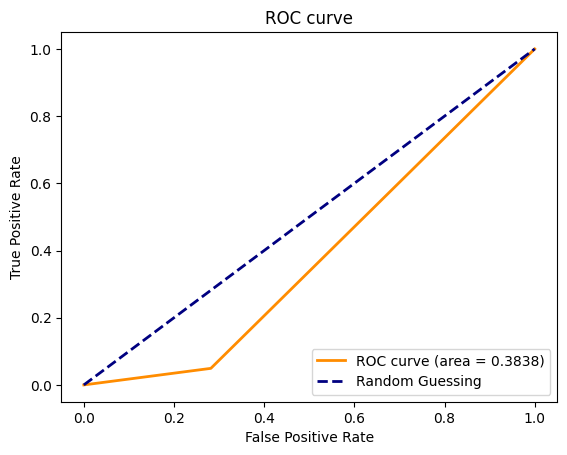

In [9]:
# roc curve for true_labels and pred_labels
from sklearn.metrics import roc_curve, auc
pred_labels_argmax = np.argmax(pred_labels, axis=1)
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels_argmax)
roc_auc = auc(fpr, tpr)
print("ROC AUC: {0:.4f}".format(roc_auc))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, pred_labels_argmax)

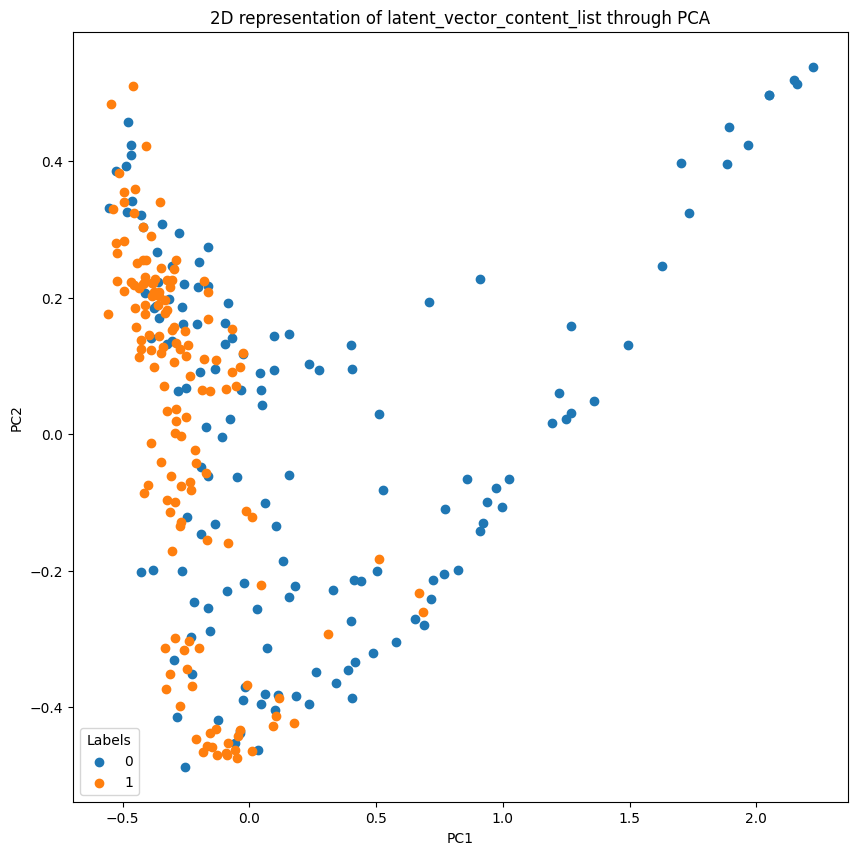

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
latent_vector_content_list_2D = pca.fit_transform(latent_vector_content_list)

# Plot 2D representation of latent_vector_content_list through PCA
plt.figure(figsize=(10, 10))

# Get unique labels
unique_labels = set(true_labels)

# Plot each class with a different color and label
for label in unique_labels:
    # Select indices corresponding to the current label
    indices = [i for i, l in enumerate(true_labels) if l == label]

    # Scatter plot for each individual class
    plt.scatter(latent_vector_content_list_2D[indices, 0], latent_vector_content_list_2D[indices, 1], label=label)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D representation of latent_vector_content_list through PCA')

# Add legend
plt.legend(title='Labels')

# Show plot
plt.show()


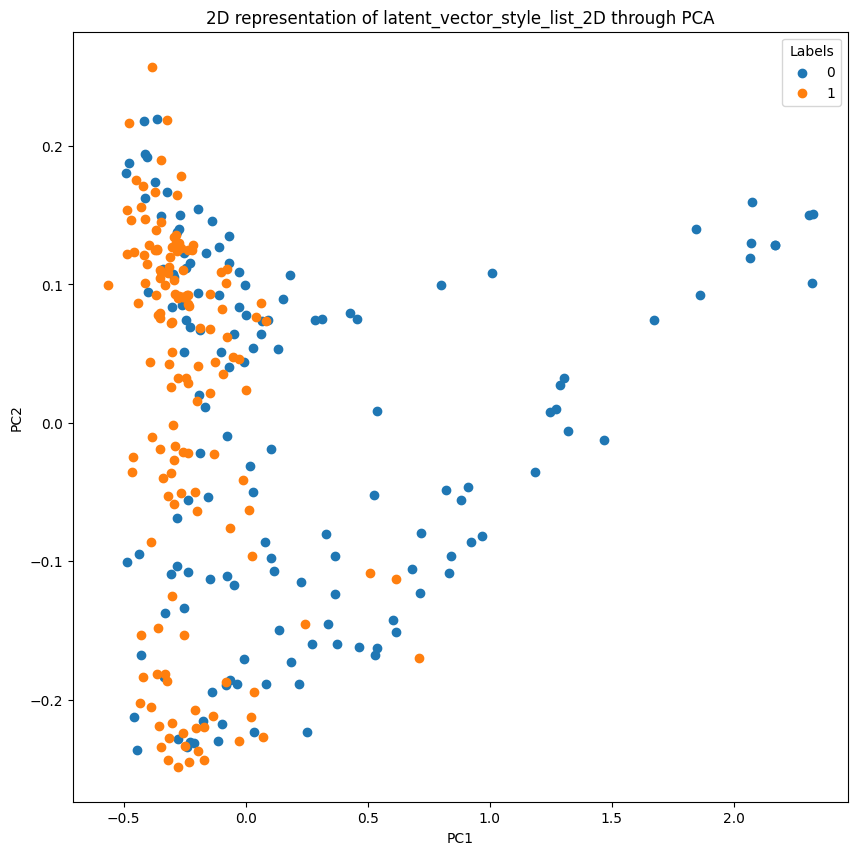

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA on latent_vector_style_list
pca = PCA(n_components=2)
latent_vector_style_list_2D = pca.fit_transform(latent_vector_style_list)

# Plot 2D representation of latent_vector_style_list through PCA
plt.figure(figsize=(10, 10))

# Get unique labels
unique_labels = set(true_labels)

# Plot each class with a different color and label
for label in unique_labels:
    # Select indices corresponding to the current label
    indices = [i for i, l in enumerate(true_labels) if l == label]

    # Scatter plot for each individual class
    plt.scatter(latent_vector_style_list_2D[indices, 0], latent_vector_style_list_2D[indices, 1], label=label)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D representation of latent_vector_style_list_2D through PCA')

# Add legend
plt.legend(title='Labels')

# Show plot
plt.show()
